In [151]:
import argparse
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
import sys
import matplotlib.cm as cm
import kornia as K
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
densematching_path = "/home/jireh/MT/video_sychronazation/DenseMatching"
if densematching_path not in sys.path:
    sys.path.append(densematching_path)

In [152]:
from model_selection import model_type, pre_trained_model_types, select_model
# from datasets.util import pad_to_same_shape
from utils_flow.img_processing_utils import pad_to_same_shape
torch.set_grad_enabled(False)
from utils_flow.pixel_wise_mapping import remap_using_flow_fields
from utils_flow.visualization_utils import overlay_semantic_mask, make_sparse_matching_plot
from utils_flow.util_optical_flow import flow_to_image  
from models.inference_utils import estimate_mask
from utils_flow.flow_and_mapping_operations import convert_flow_to_mapping
from validation.utils import matches_from_flow
from admin.stats import DotDict 
from model_selection import select_model
from utils_flow.visualization_utils import overlay_semantic_mask
from utils_flow.pixel_wise_mapping import remap_using_flow_fields
from demos.utils import (AverageTimer, VideoStreamer, make_matching_and_warping_plot_fast, make_matching_plot_fast)
from validation.test_parser import define_model_parser
from utils_flow.visualization_utils import make_and_save_video

torch.set_grad_enabled(False)
%matplotlib inline

==> Processing video input: /home/jireh/MT/data/hdVideos/hd_00_01.mp4
==> Processing video input: /home/jireh/MT/data/hdVideos/hd_00_04.mp4


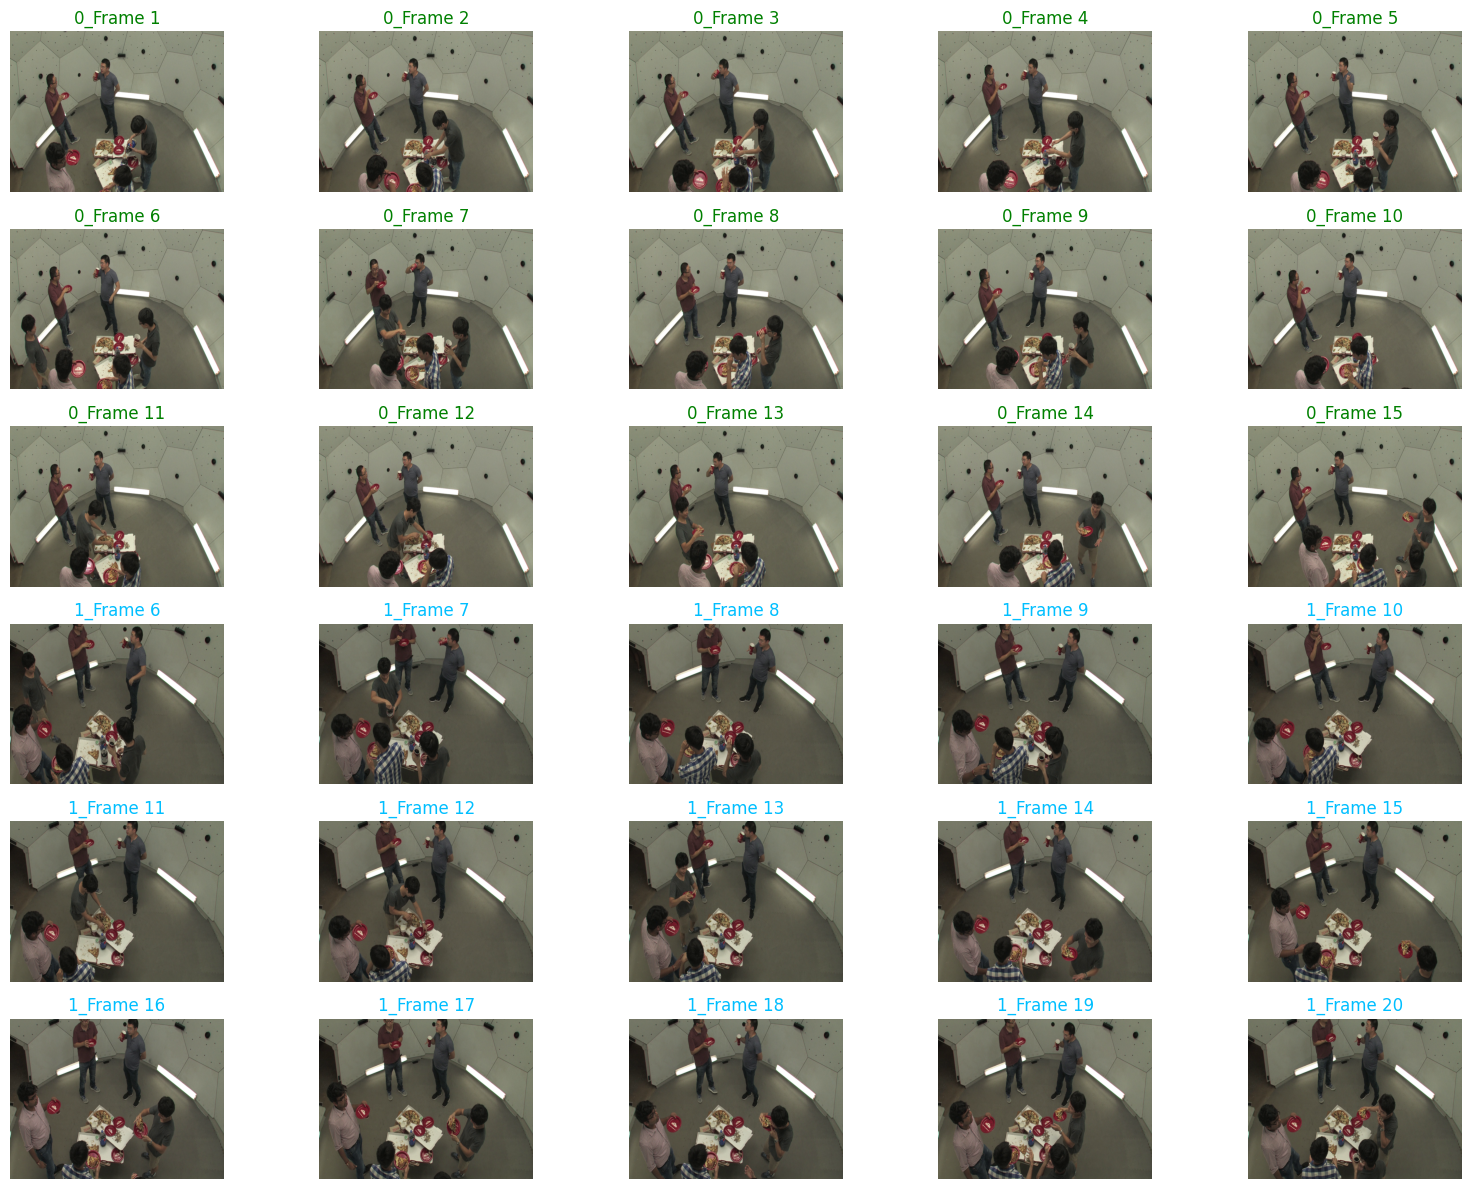

In [153]:
video_input0 = "/home/jireh/MT/data/hdVideos/hd_00_01.mp4"
video_input1 = "/home/jireh/MT/data/hdVideos/hd_00_04.mp4"
resize=[640, 480]
skip=100
image_glob=['*.png', '*.jpg', '*.jpeg']
max_length=1000000

vs0 = VideoStreamer(video_input0, resize, skip, image_glob, max_length)
vs1 = VideoStreamer(video_input1, resize, skip, image_glob, max_length)

fig,axes = plt.subplots(6,5,figsize = (16,12))
for _ in range(10):
    frame0, ret0 = vs0.next_frame()
    frame1, ret1 = vs1.next_frame()
    
frame_set0 = []
frame_set1 = []
for i in range(3):
    for j in range(5):
        frame, ret = vs0.next_frame()
        assert ret, 'Error when reading the first frame (try different --input?)'
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        axes[i,j].imshow(frame)
        axes[i, j].axis('off')  
        axes[i, j].set_title(f"0_Frame {i*5+j+1}",color='green')
        frame_set0.append(frame)

#video1 shift 5 frames
for _ in range(5):
    frame, ret = vs1.next_frame()

for i in range(3):
    for j in range(5):
        frame, ret = vs1.next_frame()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        assert ret, 'Error when reading the first frame (try different --input?)'
        axes[i+3,j].imshow(frame)
        axes[i+3, j].axis('off')  
        axes[i+3, j].set_title(f"1_Frame {i*5+j+6}",color='deepskyblue')
        frame_set1.append(frame)

plt.tight_layout()
plt.savefig("Frame.png")
plt.show()

In [154]:
# Choose the model, and run it to estimate the flow field relating the image pair
print('Possible model types are:')
print(model_type)
print('\nPossible pre-trained model types are:')
print(pre_trained_model_types)

Possible model types are:
['GLUNet', 'GLUNet_interp', 'GLUNet_GOCor', 'PWCNet', 'PWCNet_GOCor', 'GLUNet_GOCor_star', 'PDCNet', 'PDCNet_plus', 'GLUNet_star', 'WarpCGLUNet', 'SemanticGLUNet', 'WarpCSemanticGLUNet', 'WarpCGLUNet_interp', 'UAWarpC', 'SFNet', 'PWarpCSFNet_WS', 'PWarpCSFNet_SS', 'NCNet', 'PWarpCNCNet_WS', 'PWarpCNCNet_SS', 'CATs', 'PWarpCCATs_SS', 'CATs_ft_features', 'PWarpCCATs_ft_features_SS']

Possible pre-trained model types are:
['static', 'dynamic', 'chairs_things', 'chairs_things_ft_sintel', 'megadepth', 'megadepth_stage1', 'pfpascal', 'spair']


In [157]:
class denseMatching():
    def __init__(self):
        model = 'PDCNet_plus'
        pre_trained_model = 'megadepth'
        flipping_condition = False 
        global_optim_iter = 3
        local_optim_iter = 7 
        path_to_pre_trained_models = '/home/jireh/MT/video_sychronazation/DenseMatching/pre_trained_models' 
        # inference parameters for PDC-Net
        network_type = model  # will only use these arguments if the network_type is 'PDCNet' or 'PDCNet_plus'
        choices_for_multi_stage_types = ['d', 'h', 'ms']
        multi_stage_type = 'h'
        confidence_map_R =1.0
        ransac_thresh = 1.0
        mask_type = 'proba_interval_1_above_10'  # for internal homo estimation
        homography_visibility_mask = True
        scaling_factors = [0.5, 0.6, 0.88, 1, 1.33, 1.66, 2]
        compute_cyclic_consistency_error = True  # here to compare multiple uncertainty
        confident_mask_type="proba_interval_1_above_10"
        self.args = DotDict({'network_type': network_type, 'multi_stage_type': multi_stage_type, 'confidence_map_R': confidence_map_R, 
                'ransac_thresh': ransac_thresh, 'mask_type': mask_type, 
                'homography_visibility_mask': homography_visibility_mask, 'scaling_factors': scaling_factors, 
                'compute_cyclic_consistency_error': compute_cyclic_consistency_error})
        
        self.network, self.estimate_uncertainty = select_model(
        model, pre_trained_model, args, global_optim_iter, local_optim_iter,
        path_to_pre_trained_models=path_to_pre_trained_models)
        
    def get_matches_and_confidence(self,img0,img1,conf_threshold):
        self.img0 = img0
        self.img1 = img1
        self.pred = self.network.get_matches_and_confidence(target_img=torch.from_numpy(self.img0).permute(2, 0, 1)
                                                  .unsqueeze(0), source_img=torch.from_numpy(self.img1).permute(2, 0, 1)
                                                  .unsqueeze(0), confident_mask_type=confident_mask_type)
        mkpts0 = pred['kp_target']
        mkpts1 = pred['kp_source']
        mconf = pred['confidence_value']
        
        ind = mconf> conf_threshold
        total_n_matches = ind.sum()
        self.mkpts0 = mkpts0[ind]
        self.mkpts1 = mkpts1[ind]
        self.mconf = mconf[ind]
        
        return mkpts0,mkpts1,mconf
    
    def visualize_matches(self):
        total_n_matches  = len(self.mkpts0)
        # select only a subset of matches (the most confident)
        mkpts_vis0 = self.mkpts0[:5000:100]
        mkpts_vis1 = self.mkpts1[:5000:100]
        mconf_vis = self.mconf[:5000:100]
        
        # Normalize confidence.
        if len(mconf_vis) > 0:
            conf_vis_min = 0.
            conf_min = mconf_vis.min()
            conf_max = mconf_vis.max()
            mconf_vis = (mconf_vis - conf_vis_min) / (conf_max - conf_vis_min + 1e-5)
        
        #Low values map to blue, medium values map to green, and high values map to red.
        alpha = 0
        color = cm.jet(mconf_vis, alpha=alpha) 
        text = [
                    f"dense matching",
                    'Top 1000 Matches out of {}'.format(total_n_matches),
                ]
        #wraped image
        flow_t_to_s = pred['flow'].squeeze().permute(1, 2, 0).cpu().numpy()
        mask_t_to_s = pred['mask'].squeeze().float().cpu().numpy()
        small_text = [
            'Mask type: {} '.format(confident_mask_type)
        ]
        warped_frame = remap_using_flow_fields(self.img1, flow_t_to_s[:, :, 0], flow_t_to_s[:, :, 1]).astype(np.uint8)
        warped_and_overlay_image = overlay_semantic_mask(warped_frame,
                                                                         ann=255 - mask_t_to_s.astype(np.uint8) * 255,
                                                                         color=[51, 102, 255])  # BGR instead of RGB
        small_text.append('(red regions are predicted uncertain in the 3rd image)')
        out = make_matching_and_warping_plot_fast(
                        self.img0, self.img1, kpts0=None, kpts1=None, mkpts0=mkpts_vis0, mkpts1=mkpts_vis1, color=color, text=text,
                        warped_and_overlay_image=warped_and_overlay_image, path=None, show_keypoints=False,
                        small_text=small_text)
        
        #withour warping
        # out = make_matching_plot_fast(
        #                 img1,img0, kpts0=None, kpts1=None, mkpts0=mkpts_vis0, mkpts1=mkpts_vis1, color=color, text=text,
        #                 path=None, show_keypoints=False, small_text=small_text,warped_and_overlay_image=None)
        
        plt.figure(figsize=(60,45))
        plt.imshow(out)
        plt.axis('off')  
        plt.show()

Model: PDCNet_plus
Pre-trained-model: megadepth
GOCor: Local iter 7
GOCor: Global iter 3


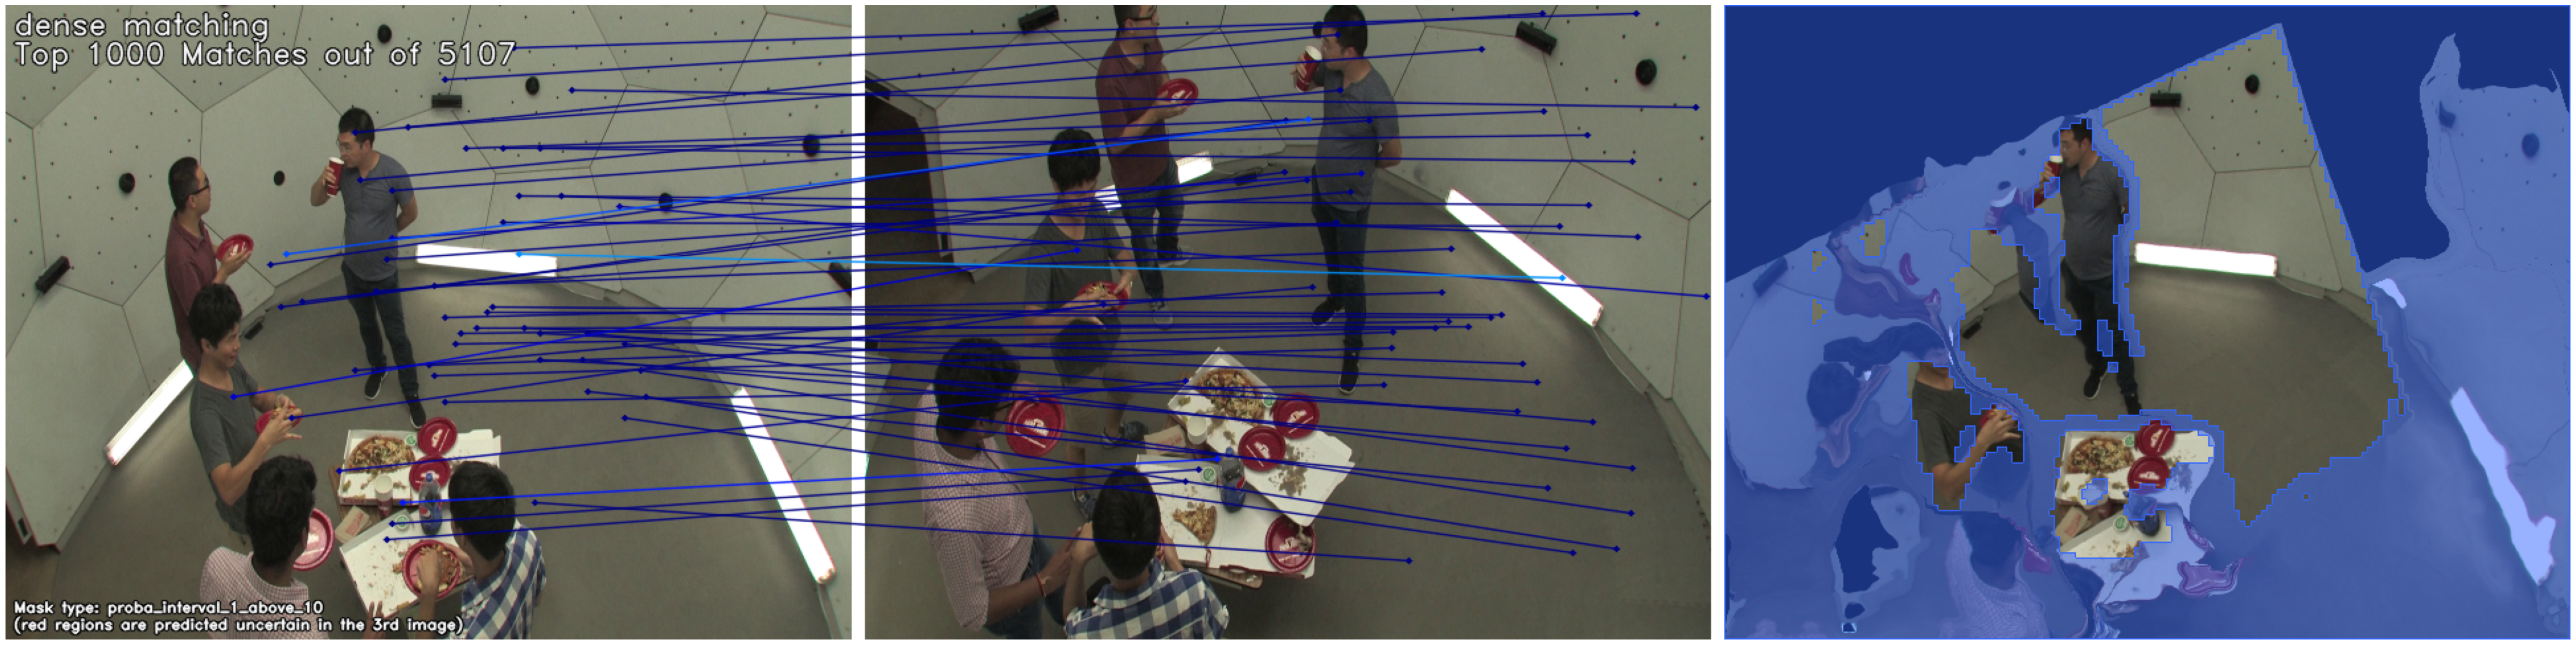

(5493, 2)


In [158]:
img0 = frame_set0[12]
img1 = frame_set1[7]

dm = denseMatching()
mkpts0,mkpts1,mconf = dm.get_matches_and_confidence(img0,img1,0.3)
dm.visualize_matches()
print(mkpts1.shape)

## fundamental matrix and visualize epipolar lines

In [159]:
import torch

scale_x = 640 / 1920
scale_y = 480 / 1080
cam0 = {
    "K": torch.tensor([[1395.91 * scale_x, 0.0, 951.559 * scale_x],
                       [0.0, 1392.24 * scale_y, 561.398 * scale_y],
                       [0.0, 0.0, 1.0]]),
    "R": torch.tensor([[0.05337497606, 0.02479711619, 0.9982666052],
                       [0.6376765256, 0.7684660834, -0.05318390075],
                       [-0.7684528356, 0.6394098699, 0.0252043199]]),
    "t": torch.tensor([[6.299256813],
                       [104.397182],
                       [363.078698]])
}
cam1 = {
    "K": torch.tensor([[1633.26 * scale_x, 0.0, 949.479 * scale_x],
                       [0.0, 1629.32 * scale_y , 572.374 * scale_y],
                       [0.0, 0.0, 1.0]]),
    "R": torch.tensor([[-0.5292732399, -0.01229259603, 0.8483623811],
                       [0.636650989, 0.6551966806, 0.4066851706],
                       [-0.5608434325, 0.7553583268, -0.3389519765]]),
    "t": torch.tensor([[-5.411400695],
                       [80.12176746],
                       [379.8488129]])
}

K0, K1 = cam0["K"], cam1["K"]
R0, R1 = cam0["R"], cam1["R"]
t0, t1 = cam0["t"], cam1["t"]

E_mat = K.geometry.epipolar.essential_from_Rt(R0, t0, R1, t1)
F_mat = K.geometry.epipolar.fundamental_from_essential(E_mat, K0, K1)

print("Fundamental matrix: \n", F_mat)

def draw_epilines(image1,points,image2,Fm):
    """
    For verifing Fm.
    Draw epilines on image2 and corresponding points on image1.
    """
    lines2 = cv2.computeCorrespondEpilines(mkpts0, 1, Fm)
    lines2 = lines2.reshape(-1, 3)

    for r, pt in zip(lines2, points):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [image2.shape[1], -(r[2]+r[0]*image2.shape[1])/r[1]])
        image1 = cv2.circle(image1, tuple(map(int, pt)), 5, color, -1)
        image2 = cv2.line(image2, (x0, y0), (x1, y1), color, 1)
    return image1, image2

def visualize_epipolarline(image1,points,image2,Fm):
    image1_with_points, image2_with_lines = draw_epilines(image1, mkpts0[:100], image2, Fm)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(image1_with_points)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(image2_with_lines)
    plt.axis('off')
    plt.show()
    
visualize_epipolarline(img0,mkpts0,img1,np.array(F_mat))

Fundamental matrix: 
 tensor([[-5.9504e-05, -6.9686e-05,  4.9947e-02],
        [-5.8388e-05,  4.1050e-05,  1.7744e-01],
        [-9.7330e-02, -1.5972e-01,  2.8025e+01]])


## Draft below

In [85]:
# choose model 
model = 'PDCNet_plus'
pre_trained_model = 'megadepth'
flipping_condition = False 
global_optim_iter = 3
local_optim_iter = 7 
path_to_pre_trained_models = '/home/jireh/MT/video_sychronazation/DenseMatching/pre_trained_models' 
    
if model not in model_type:
    raise ValueError('The model that you chose is not valid: {}'.format(model))
if pre_trained_model not in pre_trained_model_types:
    raise ValueError('The pre-trained model type that you chose is not valid: {}'.format(pre_trained_model))

# inference parameters for PDC-Net
network_type = model  # will only use these arguments if the network_type is 'PDCNet' or 'PDCNet_plus'
choices_for_multi_stage_types = ['d', 'h', 'ms']
multi_stage_type = 'h'
if multi_stage_type not in choices_for_multi_stage_types:
    raise ValueError('The inference mode that you chose is not valid: {}'.format(multi_stage_type))

confidence_map_R =1.0
ransac_thresh = 1.0
mask_type = 'proba_interval_1_above_10'  # for internal homo estimation
homography_visibility_mask = True
scaling_factors = [0.5, 0.6, 0.88, 1, 1.33, 1.66, 2]
compute_cyclic_consistency_error = True  # here to compare multiple uncertainty
confident_mask_type="proba_interval_1_above_10"

# usually from argparse
args = DotDict({'network_type': network_type, 'multi_stage_type': multi_stage_type, 'confidence_map_R': confidence_map_R, 
                'ransac_thresh': ransac_thresh, 'mask_type': mask_type, 
                'homography_visibility_mask': homography_visibility_mask, 'scaling_factors': scaling_factors, 
                'compute_cyclic_consistency_error': compute_cyclic_consistency_error})

network, estimate_uncertainty = select_model(
        model, pre_trained_model, args, global_optim_iter, local_optim_iter,
        path_to_pre_trained_models=path_to_pre_trained_models)


pred = network.get_matches_and_confidence(target_img=torch.from_numpy(img0).permute(2, 0, 1)
                                                  .unsqueeze(0), source_img=torch.from_numpy(img1).permute(2, 0, 1)
                                                  .unsqueeze(0), confident_mask_type=confident_mask_type)
mkpts0 = pred['kp_source']
mkpts1 = pred['kp_target']
mconf = pred['confidence_value']

Model: PDCNet_plus
Pre-trained-model: megadepth
GOCor: Local iter 7
GOCor: Global iter 3
